In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from collections import defaultdict
import datetime
import pickle
import math
import os
from scipy.stats import skew, norm
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None) # no truncate columns

In [14]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "data-visualization"
with open(data_path_out + 'train_pp.obj', 'rb') as file:
    all_train = pickle.load(file)
    
all_train_orig = all_train.copy()

### Drop now useless variables

In [15]:
all_train = all_train.drop(labels = ['NumberOfCustomers'],axis=1)
all_train = all_train.drop('Date',axis=1)

In [16]:
# train = all_train[all_train['Date'] < '01-02-2018']
# test = all_train[all_train['Date'] >= '01-02-2018']
# train = train[train.StoreID == 1000]
# test = test[test.StoreID == 1000]
# y_train = train.NumberOfSales
# x_train = train.drop('NumberOfSales',axis = 1)
# y_test = test.NumberOfSales
# x_test = test.drop('NumberOfSales',axis = 1)

# x_train = x_train.drop('Date',axis=1)
# x_test = x_test.drop('Date',axis=1)

In [17]:
# params = {
#     # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # Other parameters
#     'objective':'reg:linear',
# }

In [18]:
results = {}
for storeid in all_train.StoreID.unique():
    train = all_train[all_train.StoreID == storeid]
    y_train = train.NumberOfSales
    x_train = train.drop('NumberOfSales',axis = 1)
    
    model = XGBRegressor(silent=False)
    kfold = KFold(n_splits=10,shuffle = True, random_state=7)
    results[storeid] = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold)
    print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
          .format(storeid,results[storeid].mean(),results[storeid].std()))

Cross-validation for 1000 -> score: 0.9137 with +/- 0.0224
Cross-validation for 1001 -> score: 0.8003 with +/- 0.1195
Cross-validation for 1002 -> score: 0.9452 with +/- 0.0110
Cross-validation for 1003 -> score: 0.9286 with +/- 0.0276
Cross-validation for 1004 -> score: 0.9387 with +/- 0.0238
Cross-validation for 1005 -> score: 0.9434 with +/- 0.0197
Cross-validation for 1006 -> score: 0.9071 with +/- 0.0332
Cross-validation for 1007 -> score: 0.9052 with +/- 0.0389
Cross-validation for 1008 -> score: 0.9119 with +/- 0.0177
Cross-validation for 1009 -> score: 0.9454 with +/- 0.0194
Cross-validation for 1010 -> score: 0.9273 with +/- 0.0185
Cross-validation for 1011 -> score: 0.9335 with +/- 0.0288
Cross-validation for 1012 -> score: 0.9509 with +/- 0.0120
Cross-validation for 1013 -> score: 0.9481 with +/- 0.0190
Cross-validation for 1014 -> score: 0.9351 with +/- 0.0243
Cross-validation for 1015 -> score: 0.9296 with +/- 0.0252
Cross-validation for 1016 -> score: 0.8977 with +/- 0.04

Cross-validation for 1139 -> score: 0.9204 with +/- 0.0209
Cross-validation for 1140 -> score: 0.9416 with +/- 0.0221
Cross-validation for 1141 -> score: 0.9338 with +/- 0.0289
Cross-validation for 1142 -> score: 0.9321 with +/- 0.0206
Cross-validation for 1143 -> score: 0.9220 with +/- 0.0190
Cross-validation for 1144 -> score: 0.9404 with +/- 0.0113
Cross-validation for 1145 -> score: 0.9203 with +/- 0.0273
Cross-validation for 1146 -> score: 0.9238 with +/- 0.0259
Cross-validation for 1147 -> score: 0.9335 with +/- 0.0179
Cross-validation for 1148 -> score: 0.8856 with +/- 0.0449
Cross-validation for 1149 -> score: 0.9396 with +/- 0.0157
Cross-validation for 1150 -> score: 0.9384 with +/- 0.0203
Cross-validation for 1151 -> score: 0.9078 with +/- 0.0307
Cross-validation for 1152 -> score: 0.9208 with +/- 0.0212
Cross-validation for 1153 -> score: 0.9338 with +/- 0.0172
Cross-validation for 1154 -> score: 0.9222 with +/- 0.0268
Cross-validation for 1155 -> score: 0.9573 with +/- 0.01

Cross-validation for 1278 -> score: 0.9420 with +/- 0.0243
Cross-validation for 1279 -> score: 0.9266 with +/- 0.0301
Cross-validation for 1280 -> score: 0.9342 with +/- 0.0189
Cross-validation for 1281 -> score: 0.9374 with +/- 0.0304
Cross-validation for 1282 -> score: 0.9175 with +/- 0.0414
Cross-validation for 1283 -> score: 0.9301 with +/- 0.0204
Cross-validation for 1284 -> score: 0.9311 with +/- 0.0136
Cross-validation for 1285 -> score: 0.9114 with +/- 0.0614
Cross-validation for 1286 -> score: 0.9499 with +/- 0.0146
Cross-validation for 1287 -> score: 0.9567 with +/- 0.0153
Cross-validation for 1288 -> score: 0.9425 with +/- 0.0201
Cross-validation for 1289 -> score: 0.9347 with +/- 0.0151
Cross-validation for 1290 -> score: 0.9160 with +/- 0.0317
Cross-validation for 1291 -> score: 0.9053 with +/- 0.0309
Cross-validation for 1292 -> score: 0.9450 with +/- 0.0202
Cross-validation for 1293 -> score: 0.9308 with +/- 0.0250
Cross-validation for 1294 -> score: 0.9058 with +/- 0.03

Cross-validation for 1417 -> score: 0.9296 with +/- 0.0324
Cross-validation for 1418 -> score: 0.9374 with +/- 0.0296
Cross-validation for 1419 -> score: 0.9305 with +/- 0.0296
Cross-validation for 1420 -> score: 0.9319 with +/- 0.0469
Cross-validation for 1421 -> score: 0.9173 with +/- 0.0433
Cross-validation for 1422 -> score: 0.9186 with +/- 0.0304
Cross-validation for 1423 -> score: 0.9430 with +/- 0.0192
Cross-validation for 1424 -> score: 0.9619 with +/- 0.0088
Cross-validation for 1425 -> score: 0.9526 with +/- 0.0090
Cross-validation for 1426 -> score: 0.9335 with +/- 0.0220
Cross-validation for 1427 -> score: 0.9075 with +/- 0.0594
Cross-validation for 1428 -> score: 0.9442 with +/- 0.0127
Cross-validation for 1429 -> score: 0.8333 with +/- 0.0710
Cross-validation for 1430 -> score: 0.9500 with +/- 0.0123
Cross-validation for 1431 -> score: 0.9180 with +/- 0.0302
Cross-validation for 1432 -> score: 0.9120 with +/- 0.0247
Cross-validation for 1433 -> score: 0.9071 with +/- 0.02

Cross-validation for 1556 -> score: 0.9307 with +/- 0.0306
Cross-validation for 1557 -> score: 0.9150 with +/- 0.0258
Cross-validation for 1558 -> score: 0.9249 with +/- 0.0180
Cross-validation for 1559 -> score: 0.8243 with +/- 0.0737
Cross-validation for 1560 -> score: 0.9220 with +/- 0.0270
Cross-validation for 1561 -> score: 0.9393 with +/- 0.0205
Cross-validation for 1562 -> score: 0.9400 with +/- 0.0189
Cross-validation for 1563 -> score: 0.9511 with +/- 0.0193
Cross-validation for 1564 -> score: 0.8228 with +/- 0.0929
Cross-validation for 1565 -> score: 0.9434 with +/- 0.0250
Cross-validation for 1566 -> score: 0.9373 with +/- 0.0185
Cross-validation for 1567 -> score: 0.9250 with +/- 0.0223
Cross-validation for 1568 -> score: 0.9187 with +/- 0.0170
Cross-validation for 1569 -> score: 0.9466 with +/- 0.0214
Cross-validation for 1570 -> score: 0.9550 with +/- 0.0130
Cross-validation for 1571 -> score: 0.9209 with +/- 0.0149
Cross-validation for 1572 -> score: 0.9449 with +/- 0.01

Cross-validation for 1695 -> score: 0.9568 with +/- 0.0152
Cross-validation for 1696 -> score: 0.9485 with +/- 0.0139
Cross-validation for 1697 -> score: 0.9294 with +/- 0.0287
Cross-validation for 1698 -> score: 0.9515 with +/- 0.0167
Cross-validation for 1699 -> score: 0.9491 with +/- 0.0144
Cross-validation for 1700 -> score: 0.9355 with +/- 0.0249
Cross-validation for 1701 -> score: 0.9471 with +/- 0.0211
Cross-validation for 1702 -> score: 0.9524 with +/- 0.0159
Cross-validation for 1703 -> score: 0.9294 with +/- 0.0207
Cross-validation for 1704 -> score: 0.9234 with +/- 0.0233
Cross-validation for 1705 -> score: 0.9451 with +/- 0.0221
Cross-validation for 1706 -> score: 0.9545 with +/- 0.0133
Cross-validation for 1707 -> score: 0.9294 with +/- 0.0279
Cross-validation for 1708 -> score: 0.9464 with +/- 0.0245
Cross-validation for 1709 -> score: 0.9152 with +/- 0.0232
Cross-validation for 1710 -> score: 0.9350 with +/- 0.0240
Cross-validation for 1711 -> score: 0.8591 with +/- 0.05

In [19]:
df_results = pd.DataFrame.from_dict(results).T
df_results_mean = df_results.mean(axis=1)
df_results_mean[df_results_mean < 0.8]

1194    0.756262
1267    0.783553
1330    0.518811
1339    0.733869
1546    0.418685
1729    0.583122
dtype: float64

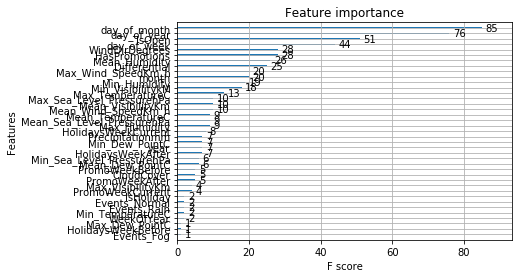

In [20]:
from xgboost import plot_importance
y_train = all_train[all_train.StoreID == 1000].NumberOfSales
x_train = all_train[all_train.StoreID == 1000].drop('NumberOfSales', axis = 1)

model = XGBRegressor(silent=False)
model.fit(x_train, y_train)
plot_importance(model);

## Lanzi Error

### Fit model and make predictions

In [21]:
# train by month
def split_dataset_bymonth(test_year, test_months, train_set):
    test_mask = (train.year == test_year) & train.month.isin(test_months)
    
    # define the train set
    train_dataset = train[~test_mask]
    x_train = train_dataset.drop('NumberOfSales', axis=1)
    y_train = train_dataset.NumberOfSales
    
    # define the test set
    test_dataset = train[test_mask]
    x_test = test_dataset.drop('NumberOfSales', axis=1)
    y_test = test_dataset.NumberOfSales
    
    return (x_train, y_train, x_test, y_test)

In [22]:
scores = {}
predictions = defaultdict(dict)

for storeid in all_train.StoreID.unique():
    # define the model
    model = XGBRegressor(silent=False)
    
    # split the dataset
    train = all_train[all_train.StoreID == storeid]
    
    x_train, y_train, x_test, y_test =\
    split_dataset_bymonth(2018, [1, 2], train)
    
    # train the model with the training set
    model.fit(x_train, y_train)
    
    # scoring
    scores[storeid] = r2_score(y_test, model.predict(x_test))
    print('store {} -> {:.4f}'.format(storeid, scores[storeid]))
    
    # predict the test set with the trained model
    for month in x_test.month.unique():
        # get daily predictions for each month in the test set
        month_prediction = model.predict(x_test[x_test.month == month])
        month_actual = y_test.loc[x_test[x_test.month == month].index].values
        
        # store the monthly mean of the test set
        predictions[storeid][month] = {
            'predicted': np.mean(month_prediction),
            'actual': np.mean(month_actual)
        }

store 1000 -> 0.8652
store 1001 -> 0.5962
store 1002 -> 0.9511
store 1003 -> 0.9387
store 1004 -> 0.9108
store 1005 -> 0.9011
store 1006 -> 0.8924
store 1007 -> 0.9358
store 1008 -> 0.0477
store 1009 -> 0.9304
store 1010 -> 0.9031
store 1011 -> 0.8352
store 1012 -> 0.9433
store 1013 -> 0.9616
store 1014 -> 0.8061
store 1015 -> 0.9033
store 1016 -> 0.8516
store 1017 -> 0.9499
store 1018 -> 0.9418
store 1019 -> 0.9342
store 1020 -> 0.9071
store 1021 -> 0.9512
store 1022 -> 0.9673
store 1023 -> 0.8942
store 1024 -> 0.9299
store 1025 -> 0.8837
store 1026 -> 0.9428
store 1027 -> 0.9403
store 1028 -> 0.8703
store 1029 -> 0.8560
store 1030 -> 0.9187
store 1031 -> 0.8838
store 1032 -> 0.9276
store 1033 -> 0.9609
store 1034 -> 0.9064
store 1035 -> 0.9215
store 1036 -> 0.9311
store 1037 -> 0.1092
store 1038 -> 0.9290
store 1039 -> 0.9611
store 1040 -> 0.9444
store 1041 -> 0.9422
store 1042 -> 0.8639
store 1043 -> 0.9108
store 1044 -> 0.9211
store 1045 -> 0.9346
store 1046 -> 0.9290
store 1047 ->

store 1390 -> 0.9091
store 1391 -> 0.8950
store 1392 -> 0.9551
store 1393 -> 0.9572
store 1394 -> 0.9380
store 1395 -> 0.9140
store 1396 -> 0.9474
store 1397 -> 0.9378
store 1398 -> 0.9502
store 1399 -> 0.8958
store 1400 -> 0.9257
store 1401 -> 0.9104
store 1402 -> 0.9627
store 1403 -> 0.9048
store 1404 -> 0.9701
store 1405 -> 0.9479
store 1406 -> 0.7971
store 1407 -> 0.6635
store 1408 -> 0.9079
store 1409 -> 0.8467
store 1410 -> 0.8263
store 1411 -> 0.9019
store 1412 -> 0.9765
store 1413 -> 0.8845
store 1414 -> 0.9497
store 1415 -> 0.9113
store 1416 -> 0.9208
store 1417 -> 0.9027
store 1418 -> 0.9489
store 1419 -> 0.9116
store 1420 -> 0.9640
store 1421 -> 0.9179
store 1422 -> 0.7244
store 1423 -> 0.9443
store 1424 -> 0.8711
store 1425 -> 0.9562
store 1426 -> 0.9436
store 1427 -> 0.9336
store 1428 -> 0.9494
store 1429 -> 0.7693
store 1430 -> 0.8399
store 1431 -> 0.9470
store 1432 -> 0.8982
store 1433 -> 0.8643
store 1434 -> 0.9427
store 1435 -> 0.9151
store 1436 -> 0.9146
store 1437 ->

### Compute Lanzi error

In [23]:
# set of regions
R = sorted(all_train_orig.Region.unique().astype(int))
# set of predicted months
months = [key for key, value in predictions[1000].items()]
# set of stores by region
dict_store_byRegion = all_train_orig[['Region', 'StoreID']].drop_duplicates()\
.set_index('StoreID').groupby('Region').groups

# region_error inputs:
#
# int region = a number from 0 to 11
# dict predictions = {
#     int storeID: {
#         int month: {
#             str 'predicted': float,
#             str 'actual': float
#         }
#         ...
#     }
#     ...
# }
def region_error(region, predictions):    
    num = 0
    den = 0
    for store in dict_store_byRegion[str(region)]:
        for month in months:
            predicted = predictions[store][month]['predicted']
            actual = predictions[store][month]['actual']
            
            num += abs(actual - predicted)
            den += actual
    
    return num/den
    
# total_error input:
#
# region_errors = [0.3, 0.5, ... ]
def total_error(region_errors):
    return sum(region_errors)/len(region_errors)

def lanzi_error(predictions):
    region_errors = []
    for r in R:
        region_errors.append(region_error(r, predictions))
    
    return total_error(region_errors)

AttributeError: 'DataFrame' object has no attribute 'Region'

In [12]:
print('Lanzi error: {}'.format(lanzi_error(predictions)))

NameError: name 'lanzi_error' is not defined